# 업종 카테고리 분류 및 분석

## 1. 개요

### 1.1 분석 목적

기존 업종 컬럼(HPSN_MCT_ZCD_NM)은 73개의 세부 업종으로 구성되어 있어 분석 및 정책 수립에 어려움이 있었다. 본 분석에서는 배달앱(땡겨요) 카테고리 기준으로 업종을 재분류하여 분석의 효율성을 높이고자 한다.

### 1.2 분석 데이터

- 데이터: big_data_merged.csv
- 관측치: 86,590개
- 기존 업종 수: 73개
- 목표: 배달앱 기준 13개 주요 카테고리 + 기타

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## 2. 데이터 로드 및 기초 탐색

In [29]:
# 데이터 로드
data_path = '/Users/yeong-gwang/Documents/배움 오전 1.38.42/외부/공모전/빅콘테스트/Project/work/ver3_/1012/data/big_data_merged.csv'
df = pd.read_csv(data_path, encoding='utf-8')

df.shape

(86590, 38)

In [30]:
# 기존 업종 분포 확인
industry_dist = df['HPSN_MCT_ZCD_NM'].value_counts()

pd.DataFrame({
    '업종명': industry_dist.index,
    '개수': industry_dist.values,
    '비율(%)': (industry_dist.values / len(df) * 100).round(2)
}).reset_index(drop=True).head(20)

,업종명,개수,비율(%)
0,한식-육류/고기,9343,10.79
1,백반/가정식,7439,8.59
2,카페,7052,8.14
3,한식-단품요리일반,6276,7.25
4,축산물,6236,7.20
5,커피전문점,3664,4.23
6,양식,3390,3.92
7,식료품,3217,3.72
8,치킨,2938,3.39
9,베이커리,2876,3.32


In [31]:
# 기존 업종 수
pd.DataFrame({
    '구분': ['총 업종 수', '총 관측치'],
    '값': [df['HPSN_MCT_ZCD_NM'].nunique(), len(df)]
})

,구분,값
0,총 업종 수,73
1,총 관측치,86590


## 3. 업종 재분류

### 3.1 분류 기준

배달앱(땡겨요) 카테고리를 기준으로 다음과 같이 분류하였다:

**13개 주요 카테고리:**
1. 치킨
2. 카페/디저트
3. 피자
4. 한식
5. 버거
6. 중식
7. 분식
8. 회/일식/돈까스
9. 도시락
10. 찜/탕
11. 족발/보쌈
12. 양식/아시안
13. 샐러드/채식

**기타 카테고리:**
- 기타-축산물: 식자재 판매업
- 기타-주점/포장마차: 주류 판매 및 주점업
- 기타-기타: 나머지 업종

### 3.2 분류 함수

In [32]:
def assign_category(industry_name):
    """
    업종명을 기준으로 배달앱 카테고리로 분류
    """
    if pd.isna(industry_name):
        return '기타-기타'
    
    # 1. 치킨
    if '치킨' in industry_name:
        return '1.치킨'
    
    # 2. 카페/디저트
    cafe_keywords = ['카페', '커피', '베이커리', '아이스크림', '빙수', '도너츠', 
                     '마카롱', '와플', '크로플', '차', '주스', '탕후루']
    if any(keyword in industry_name for keyword in cafe_keywords):
        return '2.카페/디저트'
    
    # 3. 피자
    if '피자' in industry_name:
        return '3.피자'
    
    # 5. 버거
    if '햄버거' in industry_name or '버거' in industry_name:
        return '5.버거'
    
    # 6. 중식
    if '중식' in industry_name:
        return '6.중식'
    
    # 7. 분식
    if '분식' in industry_name:
        return '7.분식'
    
    # 8. 회/일식/돈까스
    sushi_keywords = ['일식', '회', '초밥', '사시미', '돈가스', '덮밥', '이자카야', 
                      '오뎅', '라멘', '우동', '소바']
    if any(keyword in industry_name for keyword in sushi_keywords):
        return '8.회/일식/돈까스'
    
    # 9. 도시락
    if '도시락' in industry_name:
        return '9.도시락'
    
    # 10. 찜/탕 (국밥/설렁탕 제외)
    jjim_keywords = ['찜', '탕']
    if any(keyword in industry_name for keyword in jjim_keywords):
        if '국밥' not in industry_name and '설렁탕' not in industry_name:
            return '10.찜/탕'
    
    # 11. 족발/보쌈
    if '족발' in industry_name or '보쌈' in industry_name:
        return '11.족발/보쌈'
    
    # 12. 양식/아시안
    western_keywords = ['양식', '스테이크', '파스타', '레스토랑', '동남아', '인도', 
                        '타이', '베트남', '멕시칸', '터키', '퓨전']
    if any(keyword in industry_name for keyword in western_keywords):
        return '12.양식/아시안'
    
    # 13. 샐러드/채식
    salad_keywords = ['샐러드', '채식', '샌드위치', '토스트']
    if any(keyword in industry_name for keyword in salad_keywords):
        return '13.샐러드/채식'
    
    # 기타-축산물
    if '축산물' in industry_name:
        return '기타-축산물'
    
    # 기타-주점/포장마차
    jujeom_keywords = ['요리주점', '포장마차', '호프', '맥주', '유흥주점', '와인바', '룸살롱', '단란주점']
    if any(keyword in industry_name for keyword in jujeom_keywords):
        return '기타-주점/포장마차'
    
    # 4. 한식 (국밥/설렁탕 포함)
    korean_keywords = ['한식', '백반', '가정식', '한정식', '국수', '만두', '찌개', '전골', 
                       '냉면', '죽', '두부', '구내식당', '푸드코트', '기사식당', '민속주점',
                       '육류', '고기', '해물', '생선', '국밥', '설렁탕']
    if any(keyword in industry_name for keyword in korean_keywords):
        return '4.한식'
    
    return '기타-기타'

# 분류 적용
df['업종분류'] = df['HPSN_MCT_ZCD_NM'].apply(assign_category)

### 3.3 분류 결과

In [33]:
# 카테고리별 분포
category_dist = df['업종분류'].value_counts().sort_index()

result_df = pd.DataFrame({
    '카테고리': category_dist.index,
    '개수': category_dist.values,
    '비율(%)': (category_dist.values / len(df) * 100).round(2)
}).reset_index(drop=True)

result_df

,카테고리,개수,비율(%)
0,1.치킨,2938,3.39
1,10.찜/탕,296,0.34
2,12.양식/아시안,4072,4.70
3,13.샐러드/채식,632,0.73
4,2.카페/디저트,15975,18.45
5,3.피자,1123,1.30
6,4.한식,30332,35.03
7,5.버거,612,0.71
8,6.중식,2279,2.63
9,7.분식,2867,3.31


In [34]:
# 13개 주요 카테고리 vs 기타
main_categories = ['1.치킨', '2.카페/디저트', '3.피자', '4.한식', '5.버거', '6.중식', 
                   '7.분식', '8.회/일식/돈까스', '9.도시락', '10.찜/탕', '11.족발/보쌈',
                   '12.양식/아시안', '13.샐러드/채식']

main_count = df[df['업종분류'].isin(main_categories)].shape[0]
etc_count = df[~df['업종분류'].isin(main_categories)].shape[0]

pd.DataFrame({
    '구분': ['13개 주요 카테고리', '기타 카테고리', '전체'],
    '개수': [main_count, etc_count, len(df)],
    '비율(%)': [
        round(main_count / len(df) * 100, 2),
        round(etc_count / len(df) * 100, 2),
        100.0
    ]
})


,구분,개수,비율(%)
0,13개 주요 카테고리,65891,76.1
1,기타 카테고리,20699,23.9
2,전체,86590,100.0


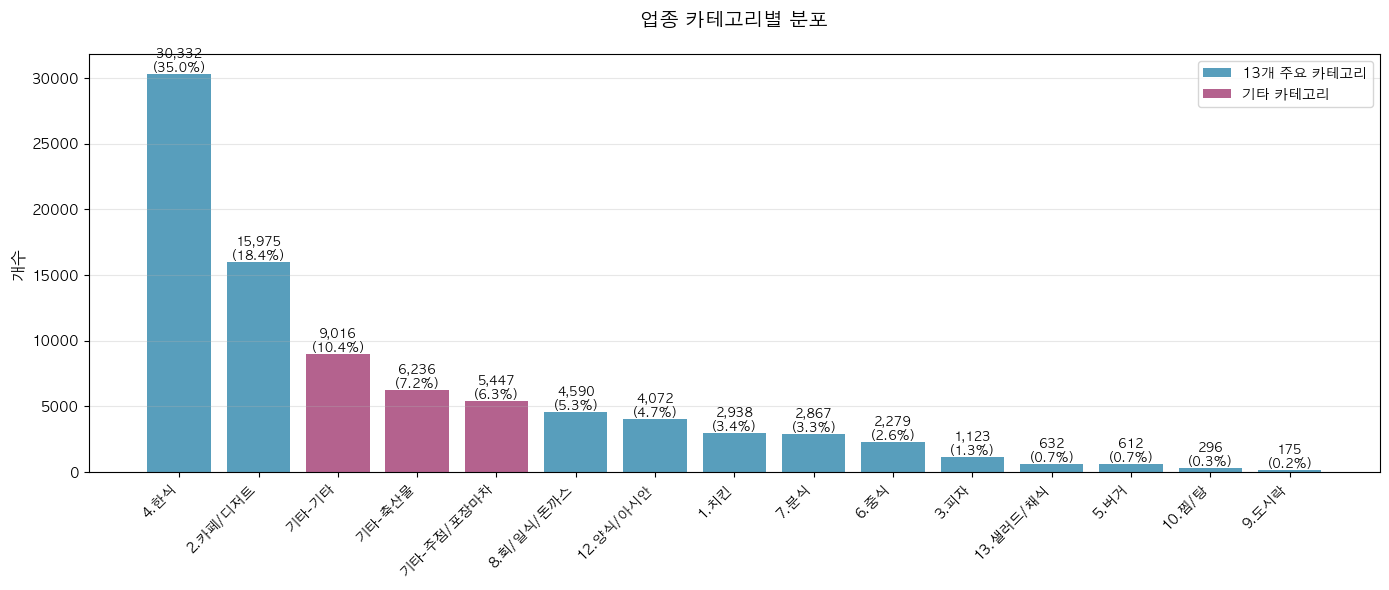

In [35]:
# 카테고리별 분포 시각화
fig, ax = plt.subplots(figsize=(14, 6))

result_df_sorted = result_df.sort_values('개수', ascending=False)
colors = ['#2E86AB' if cat in main_categories else '#A23B72' for cat in result_df_sorted['카테고리']]

bars = ax.bar(range(len(result_df_sorted)), result_df_sorted['개수'], color=colors, alpha=0.8)
ax.set_xticks(range(len(result_df_sorted)))
ax.set_xticklabels(result_df_sorted['카테고리'], rotation=45, ha='right')
ax.set_ylabel('개수', fontsize=12)
ax.set_title('업종 카테고리별 분포', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

for i, (idx, row) in enumerate(result_df_sorted.iterrows()):
    ax.text(i, row['개수'], f"{row['개수']:,}\n({row['비율(%)']:.1f}%)", 
            ha='center', va='bottom', fontsize=9)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86AB', alpha=0.8, label='13개 주요 카테고리'),
                   Patch(facecolor='#A23B72', alpha=0.8, label='기타 카테고리')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

### 3.4 분류 상세 (업종 매핑 테이블)

In [36]:
# 업종명 → 카테고리 매핑
mapping_df = df.groupby(['HPSN_MCT_ZCD_NM', '업종분류']).size().reset_index(name='개수')
mapping_df = mapping_df.sort_values(['업종분류', '개수'], ascending=[True, False])
mapping_df = mapping_df.reset_index(drop=True)

mapping_df.head(30)

,HPSN_MCT_ZCD_NM,업종분류,개수
0,치킨,1.치킨,2938
1,한식-감자탕,10.찜/탕,296
2,양식,12.양식/아시안,3390
3,동남아/인도음식,12.양식/아시안,663
4,스테이크,12.양식/아시안,19
5,샌드위치/토스트,13.샐러드/채식,632
6,카페,2.카페/디저트,7052
7,커피전문점,2.카페/디저트,3664
8,베이커리,2.카페/디저트,2876
9,아이스크림/빙수,2.카페/디저트,1108


## 4. 한식 카테고리 세부 분석

### 4.1 한식 카테고리 현황

한식 카테고리는 30,332개(35.03%)로 전체 데이터의 가장 큰 비중을 차지한다. 타 카테고리 대비 데이터 수가 많아 세부적인 분석이 필요하다고 판단하였다.

In [37]:
# 한식 세부 업종 분포
korean_df = df[df['업종분류'] == '4.한식']
korean_industry_dist = korean_df['HPSN_MCT_ZCD_NM'].value_counts()

pd.DataFrame({
    '한식 세부 업종': korean_industry_dist.index,
    '개수': korean_industry_dist.values,
    '한식 내 비율(%)': (korean_industry_dist.values / len(korean_df) * 100).round(2),
    '전체 대비 비율(%)': (korean_industry_dist.values / len(df) * 100).round(2)
}).reset_index(drop=True)

,한식 세부 업종,개수,한식 내 비율(%),전체 대비 비율(%)
0,한식-육류/고기,9343,30.80,10.79
1,백반/가정식,7439,24.53,8.59
2,한식-단품요리일반,6276,20.69,7.25
3,한식-해물/생선,2597,8.56,3.00
4,한식-국수/만두,1352,4.46,1.56
5,한식-국밥/설렁탕,1261,4.16,1.46
6,한식-찌개/전골,960,3.16,1.11
7,한식-냉면,408,1.35,0.47
8,한식뷔페,335,1.10,0.39
9,한식-죽,184,0.61,0.21


### 4.2 배달 관련 지표 분석

한식 카테고리 내부에서 각 세부 업종 간 배달 관련 지표에 차이가 있는지 확인하였다.

In [38]:
# 배달비율 데이터 전처리
df_clean = df[df['DLV_SAA_RAT'] != -999999.9].copy()
df_clean = df_clean[df_clean['DLV_SAA_RAT'].notna()].copy()

# 한식 업종만 필터링
korean_keywords = ['한식', '백반', '가정식', '한정식', '국수', '만두', '찌개', '전골', 
                   '냉면', '죽', '두부', '구내식당', '푸드코트', '기사식당', '민속주점',
                   '육류', '고기', '해물', '생선', '국밥', '설렁탕']

df_korean = df_clean[df_clean['HPSN_MCT_ZCD_NM'].apply(
    lambda x: any(keyword in str(x) for keyword in korean_keywords) if pd.notna(x) else False
)].copy()

In [39]:
# 한식 세부 업종별 배달비율 통계
korean_delivery_stats = df_korean.groupby('HPSN_MCT_ZCD_NM')['DLV_SAA_RAT'].agg([
    ('관측치수', 'count'),
    ('평균(%)', 'mean'),
    ('중앙값(%)', 'median'),
    ('표준편차', 'std'),
    ('20%초과_비율(%)', lambda x: (x > 20).sum() / len(x) * 100),
    ('25%초과_비율(%)', lambda x: (x > 25).sum() / len(x) * 100)
]).round(2)

korean_delivery_stats = korean_delivery_stats.sort_values('관측치수', ascending=False)
korean_delivery_stats

,관측치수,평균(%),중앙값(%),표준편차,20%초과_비율(%),25%초과_비율(%)
HPSN_MCT_ZCD_NM,,,,,,
한식-육류/고기,3153,27.08,13.90,31.40,43.07,37.20
한식-단품요리일반,2247,35.78,24.20,33.71,54.65,49.27
백반/가정식,1915,33.71,15.30,37.94,43.34,39.01
한식-해물/생선,1023,26.94,7.80,34.93,35.09,32.26
한식-찌개/전골,483,23.13,11.20,27.29,38.51,32.71
한식-국수/만두,469,12.92,10.80,10.18,21.75,13.22
한식-국밥/설렁탕,443,19.50,11.80,22.79,37.25,31.83
한식-죽,183,36.56,32.10,15.58,86.34,71.58
한식-냉면,146,28.58,20.15,29.75,50.00,41.78


In [40]:
# 배달비율 기준 그룹화
high_delivery = korean_delivery_stats[korean_delivery_stats['평균(%)'] >= 30]
mid_delivery = korean_delivery_stats[(korean_delivery_stats['평균(%)'] >= 20) & (korean_delivery_stats['평균(%)'] < 30)]
low_delivery = korean_delivery_stats[korean_delivery_stats['평균(%)'] < 20]

group_summary = pd.DataFrame([
    {'그룹': '고배달(30% 이상)', '업종수': len(high_delivery), '총 관측치': high_delivery['관측치수'].sum(), 
     '평균 배달비율(%)': (high_delivery['평균(%)'] * high_delivery['관측치수']).sum() / high_delivery['관측치수'].sum()},
    {'그룹': '중배달(20-30%)', '업종수': len(mid_delivery), '총 관측치': mid_delivery['관측치수'].sum(),
     '평균 배달비율(%)': (mid_delivery['평균(%)'] * mid_delivery['관측치수']).sum() / mid_delivery['관측치수'].sum()},
    {'그룹': '저배달(20% 미만)', '업종수': len(low_delivery), '총 관측치': low_delivery['관측치수'].sum(),
     '평균 배달비율(%)': (low_delivery['평균(%)'] * low_delivery['관측치수']).sum() / low_delivery['관측치수'].sum()}
]).round(2)

group_summary

,그룹,업종수,총 관측치,평균 배달비율(%)
0,고배달(30% 이상),4,4351,34.95
1,중배달(20-30%),6,4908,26.59
2,저배달(20% 미만),4,921,15.97


### 4.3 Cohen's d 효과크기 분석

한식 내부 그룹 간 배달비율 차이가 통계적으로 유의미한지 확인하기 위해 Cohen's d 효과크기를 계산하였다.

**Cohen's d 해석 기준:**
- 0.2 미만: 매우 작은 차이
- 0.2~0.5: 작은 차이
- 0.5~0.8: 중간 차이
- 0.8 이상: 큰 차이

In [41]:
def cohens_d(group1, group2):
    """
    Cohen's d 효과크기 계산
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

# 그룹 정의
group_high = df_korean[df_korean['HPSN_MCT_ZCD_NM'].str.contains('백반|가정식|단품요리', na=False)]['DLV_SAA_RAT']
group_mid = df_korean[df_korean['HPSN_MCT_ZCD_NM'].str.contains('육류|고기|해물|생선', na=False)]['DLV_SAA_RAT']
group_low_jjim = df_korean[df_korean['HPSN_MCT_ZCD_NM'].str.contains('국밥|설렁탕|찌개|전골|감자탕', na=False)]['DLV_SAA_RAT']
group_low_noodle = df_korean[df_korean['HPSN_MCT_ZCD_NM'].str.contains('국수|만두', na=False)]['DLV_SAA_RAT']

# Cohen's d 계산
comparisons = [
    ('고배달(백반/단품)', '저배달(국밥/찌개/탕)', group_high, group_low_jjim),
    ('고배달(백반/단품)', '저배달(국수/만두)', group_high, group_low_noodle),
    ('중배달(고기/해물)', '저배달(국밥/찌개/탕)', group_mid, group_low_jjim),
    ('중배달(고기/해물)', '저배달(국수/만두)', group_mid, group_low_noodle),
    ('고배달(백반/단품)', '중배달(고기/해물)', group_high, group_mid),
    ('저배달(국밥/찌개/탕)', '저배달(국수/만두)', group_low_jjim, group_low_noodle)
]

results = []
for group1_name, group2_name, group1_data, group2_data in comparisons:
    d = cohens_d(group1_data, group2_data)
    
    if abs(d) < 0.2:
        effect = "매우 작음"
    elif abs(d) < 0.5:
        effect = "작음"
    elif abs(d) < 0.8:
        effect = "중간"
    else:
        effect = "큼"
    
    results.append({
        '비교 그룹': f"{group1_name} vs {group2_name}",
        "Cohen's d": round(d, 3),
        '효과크기': effect,
        'Group1_N': len(group1_data),
        'Group1_평균': round(group1_data.mean(), 2),
        'Group2_N': len(group2_data),
        'Group2_평균': round(group2_data.mean(), 2)
    })

cohens_d_df = pd.DataFrame(results)
cohens_d_df

,비교 그룹,Cohen's d,효과크기,Group1_N,Group1_평균,Group2_N,Group2_평균
0,고배달(백반/단품) vs 저배달(국밥/찌개/탕),0.399,작음,4162,34.82,1005,21.29
1,고배달(백반/단품) vs 저배달(국수/만두),0.622,중간,4162,34.82,475,13.63
2,중배달(고기/해물) vs 저배달(국밥/찌개/탕),0.186,매우 작음,4176,27.04,1005,21.29
3,중배달(고기/해물) vs 저배달(국수/만두),0.435,작음,4176,27.04,475,13.63
4,고배달(백반/단품) vs 중배달(고기/해물),0.228,작음,4162,34.82,4176,27.04
5,저배달(국밥/찌개/탕) vs 저배달(국수/만두),0.356,작음,1005,21.29,475,13.63


### 4.4 한식 세부 분석 결론

Cohen's d 분석 결과, 한식 내부 그룹 간 배달비율 차이는 대부분 0.2~0.5 수준으로 "작은 차이"에 해당하였다. 고배달 그룹과 저배달(국수/만두) 그룹 간에만 d=0.622로 "중간 차이"를 보였으나, 국수/만두는 475개(한식의 4.7%)로 소수이며, 한식 카테고리를 세분화할 경우 카테고리 구조가 복잡해지는 문제가 있다.

따라서 배달앱 분류 기준과의 일치성, 구조의 단순성, 실무 적용성을 고려하여 한식 카테고리를 통합 유지하는 것으로 결정하였다. 다만, 세부 분석 시 한식 내부 업종별 특성을 고려할 필요가 있음을 확인하였다.

## 5. 축산물/주점/포장마차 처리

### 5.1 배달앱에 존재하지 않는 업종

축산물, 주점류, 포장마차는 배달앱 카테고리에 존재하지 않는 업종이다. 이들 업종의 배달 특성을 분석하여 적절한 분류 방안을 도출하였다.

In [42]:
# 축산물 분석
chuksan = df_clean[df_clean['HPSN_MCT_ZCD_NM'].str.contains('축산물', na=False)]

# 주점류 분석
jujeom_keywords = ['요리주점', '포장마차', '호프', '맥주', '유흥주점', '와인바', '룸살롱', '단란주점']
jujeom = df_clean[df_clean['HPSN_MCT_ZCD_NM'].apply(
    lambda x: any(keyword in str(x) for keyword in jujeom_keywords) if pd.notna(x) else False
)]

special_groups = pd.DataFrame([
    {
        '구분': '축산물',
        '관측치수': len(chuksan),
        '평균_배달비율(%)': chuksan['DLV_SAA_RAT'].mean(),
        '중앙값(%)': chuksan['DLV_SAA_RAT'].median(),
        '표준편차': chuksan['DLV_SAA_RAT'].std(),
        '20%초과_비율(%)': (chuksan['DLV_SAA_RAT'] > 20).sum() / len(chuksan) * 100
    },
    {
        '구분': '주점/포장마차',
        '관측치수': len(jujeom),
        '평균_배달비율(%)': jujeom['DLV_SAA_RAT'].mean(),
        '중앙값(%)': jujeom['DLV_SAA_RAT'].median(),
        '표준편차': jujeom['DLV_SAA_RAT'].std(),
        '20%초과_비율(%)': (jujeom['DLV_SAA_RAT'] > 20).sum() / len(jujeom) * 100
    }
]).round(2)

special_groups

,구분,관측치수,평균_배달비율(%),중앙값(%),표준편차,20%초과_비율(%)
0,축산물,165,18.66,2.7,31.19,25.45
1,주점/포장마차,780,17.78,5.6,26.56,27.05


In [43]:
# 주점류 세부 업종
jujeom_detail = jujeom.groupby('HPSN_MCT_ZCD_NM')['DLV_SAA_RAT'].agg([
    ('관측치', 'count'),
    ('평균(%)', 'mean'),
    ('중앙값(%)', 'median'),
    ('표준편차', 'std')
]).round(2).sort_values('관측치', ascending=False)

jujeom_detail

,관측치,평균(%),중앙값(%),표준편차
HPSN_MCT_ZCD_NM,,,,
요리주점,340,17.50,4.60,26.83
호프/맥주,267,19.84,6.70,29.35
포장마차,89,15.36,5.50,20.20
룸살롱/단란주점,48,22.93,7.35,25.50
와인바,36,4.24,3.50,3.88


In [44]:
# Cohen's d (축산물 vs 주점/포장마차)
d_special = cohens_d(chuksan['DLV_SAA_RAT'], jujeom['DLV_SAA_RAT'])

pd.DataFrame([{
    '비교': '축산물 vs 주점/포장마차',
    "Cohen's d": round(d_special, 3),
    '해석': '매우 작은 차이' if abs(d_special) < 0.2 else ('작은 차이' if abs(d_special) < 0.5 else '중간 이상 차이'),
    '축산물_평균(%)': round(chuksan['DLV_SAA_RAT'].mean(), 2),
    '주점/포장마차_평균(%)': round(jujeom['DLV_SAA_RAT'].mean(), 2)
}])

,비교,Cohen's d,해석,축산물_평균(%),주점/포장마차_평균(%)
0,축산물 vs 주점/포장마차,0.032,매우 작은 차이,18.66,17.78


### 5.2 처리 방안

축산물과 주점/포장마차의 배달비율은 유사하나(Cohen's d = 0.032), 업태 특성을 고려하여 다음과 같이 분류하였다:

- **축산물**: 6,236개로 점포 수가 많으며, 식자재 판매업으로 음식점과 업태가 다르므로 "기타-축산물"로 별도 유지
- **주점/포장마차**: 요리주점, 호프/맥주, 포장마차 등 주류 판매 및 주점업으로 특성이 유사하여 "기타-주점/포장마차"로 통합

## 6. 최종 업종 분류 결과

In [45]:
# 최종 분류 요약
final_summary = pd.DataFrame([
    {'구분': '13개 주요 카테고리', '개수': main_count, '비율(%)': round(main_count/len(df)*100, 2)},
    {'구분': '  - 1.치킨', '개수': (df['업종분류'] == '1.치킨').sum(), '비율(%)': round((df['업종분류'] == '1.치킨').sum()/len(df)*100, 2)},
    {'구분': '  - 2.카페/디저트', '개수': (df['업종분류'] == '2.카페/디저트').sum(), '비율(%)': round((df['업종분류'] == '2.카페/디저트').sum()/len(df)*100, 2)},
    {'구분': '  - 3.피자', '개수': (df['업종분류'] == '3.피자').sum(), '비율(%)': round((df['업종분류'] == '3.피자').sum()/len(df)*100, 2)},
    {'구분': '  - 4.한식', '개수': (df['업종분류'] == '4.한식').sum(), '비율(%)': round((df['업종분류'] == '4.한식').sum()/len(df)*100, 2)},
    {'구분': '  - 5.버거', '개수': (df['업종분류'] == '5.버거').sum(), '비율(%)': round((df['업종분류'] == '5.버거').sum()/len(df)*100, 2)},
    {'구분': '  - 6.중식', '개수': (df['업종분류'] == '6.중식').sum(), '비율(%)': round((df['업종분류'] == '6.중식').sum()/len(df)*100, 2)},
    {'구분': '  - 7.분식', '개수': (df['업종분류'] == '7.분식').sum(), '비율(%)': round((df['업종분류'] == '7.분식').sum()/len(df)*100, 2)},
    {'구분': '  - 8.회/일식/돈까스', '개수': (df['업종분류'] == '8.회/일식/돈까스').sum(), '비율(%)': round((df['업종분류'] == '8.회/일식/돈까스').sum()/len(df)*100, 2)},
    {'구분': '  - 9.도시락', '개수': (df['업종분류'] == '9.도시락').sum(), '비율(%)': round((df['업종분류'] == '9.도시락').sum()/len(df)*100, 2)},
    {'구분': '  - 10.찜/탕', '개수': (df['업종분류'] == '10.찜/탕').sum(), '비율(%)': round((df['업종분류'] == '10.찜/탕').sum()/len(df)*100, 2)},
    {'구분': '  - 11.족발/보쌈', '개수': (df['업종분류'] == '11.족발/보쌈').sum(), '비율(%)': round((df['업종분류'] == '11.족발/보쌈').sum()/len(df)*100, 2)},
    {'구분': '  - 12.양식/아시안', '개수': (df['업종분류'] == '12.양식/아시안').sum(), '비율(%)': round((df['업종분류'] == '12.양식/아시안').sum()/len(df)*100, 2)},
    {'구분': '  - 13.샐러드/채식', '개수': (df['업종분류'] == '13.샐러드/채식').sum(), '비율(%)': round((df['업종분류'] == '13.샐러드/채식').sum()/len(df)*100, 2)},
    {'구분': '기타 카테고리', '개수': etc_count, '비율(%)': round(etc_count/len(df)*100, 2)},
    {'구분': '  - 기타-축산물', '개수': (df['업종분류'] == '기타-축산물').sum(), '비율(%)': round((df['업종분류'] == '기타-축산물').sum()/len(df)*100, 2)},
    {'구분': '  - 기타-주점/포장마차', '개수': (df['업종분류'] == '기타-주점/포장마차').sum(), '비율(%)': round((df['업종분류'] == '기타-주점/포장마차').sum()/len(df)*100, 2)},
    {'구분': '  - 기타-기타', '개수': (df['업종분류'] == '기타-기타').sum(), '비율(%)': round((df['업종분류'] == '기타-기타').sum()/len(df)*100, 2)},
    {'구분': '전체', '개수': len(df), '비율(%)': 100.0}
])

final_summary

,구분,개수,비율(%)
0,13개 주요 카테고리,65891,76.10
1,- 1.치킨,2938,3.39
2,- 2.카페/디저트,15975,18.45
3,- 3.피자,1123,1.30
4,- 4.한식,30332,35.03
5,- 5.버거,612,0.71
6,- 6.중식,2279,2.63
7,- 7.분식,2867,3.31
8,- 8.회/일식/돈까스,4590,5.30
9,- 9.도시락,175,0.20


## 7. 업종별 특성 분석

### 7.1 카테고리별 배달비율

In [46]:
# 카테고리별 배달비율 통계
category_delivery = df_clean.groupby('업종분류')['DLV_SAA_RAT'].agg([
    ('관측치수', 'count'),
    ('평균_배달비율(%)', 'mean'),
    ('중앙값(%)', 'median'),
    ('표준편차', 'std'),
    ('20%초과_비율(%)', lambda x: (x > 20).sum() / len(x) * 100),
    ('25%초과_비율(%)', lambda x: (x > 25).sum() / len(x) * 100)
]).round(2)

category_delivery = category_delivery.sort_values('평균_배달비율(%)', ascending=False)
category_delivery

,관측치수,평균_배달비율(%),중앙값(%),표준편차,20%초과_비율(%),25%초과_비율(%)
업종분류,,,,,,
3.피자,809,50.79,54.70,29.15,79.36,78.62
1.치킨,2176,45.84,44.20,33.07,67.78,63.92
5.버거,529,37.51,37.50,18.32,80.53,74.10
7.분식,1436,37.37,30.35,32.60,56.82,53.69
13.샐러드/채식,504,35.61,31.00,23.18,72.42,61.11
9.도시락,173,33.86,26.80,23.37,71.68,54.91
12.양식/아시안,1484,31.36,21.20,30.91,51.08,45.08
4.한식,10095,29.25,15.40,32.75,44.37,38.89
6.중식,1360,28.66,16.95,27.63,45.74,39.63


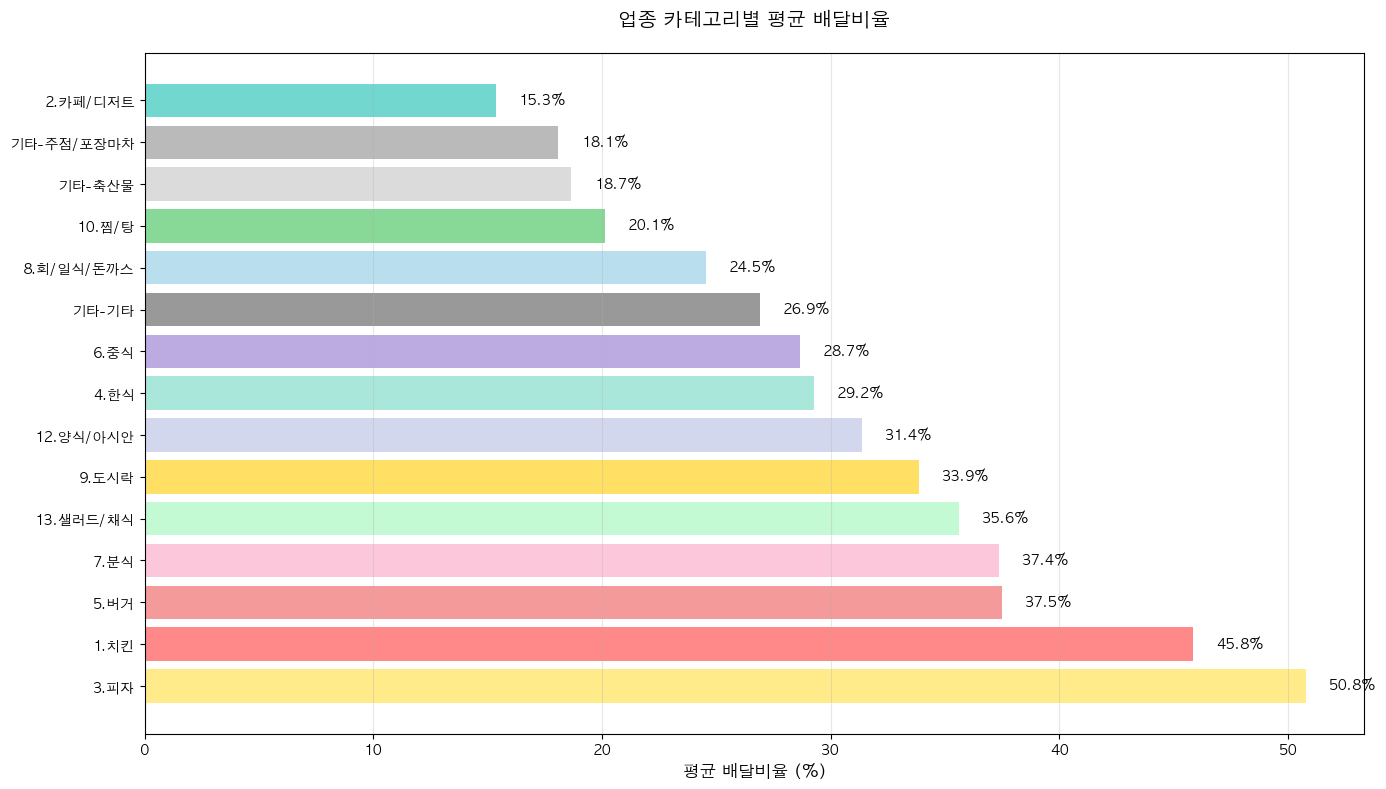

In [47]:
# 배달비율 시각화
fig, ax = plt.subplots(figsize=(14, 8))

categories = category_delivery.index.tolist()
means = category_delivery['평균_배달비율(%)'].values

colors_map = {'1.치킨': '#FF6B6B', '2.카페/디저트': '#4ECDC4', '3.피자': '#FFE66D',
              '4.한식': '#95E1D3', '5.버거': '#F38181', '6.중식': '#AA96DA',
              '7.분식': '#FCBAD3', '8.회/일식/돈까스': '#A8D8EA', '9.도시락': '#FFD93D',
              '10.찜/탕': '#6BCF7F', '12.양식/아시안': '#C7CEEA', '13.샐러드/채식': '#B4F8C8',
              '기타-축산물': '#D3D3D3', '기타-주점/포장마차': '#A9A9A9', '기타-기타': '#808080'}

bar_colors = [colors_map.get(cat, '#2E86AB') for cat in categories]

bars = ax.barh(range(len(categories)), means, color=bar_colors, alpha=0.8)
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)
ax.set_xlabel('평균 배달비율 (%)', fontsize=12)
ax.set_title('업종 카테고리별 평균 배달비율', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, (cat, mean) in enumerate(zip(categories, means)):
    ax.text(mean + 1, i, f'{mean:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 7.2 카테고리별 매출등급 분포

In [48]:
# 매출등급 분포 (상위 5개 카테고리)
top5_categories = result_df.nlargest(5, '개수')['카테고리'].tolist()

sales_dist = df[df['업종분류'].isin(top5_categories)].groupby(['업종분류', 'RC_M1_SAA']).size().unstack(fill_value=0)
sales_dist_pct = sales_dist.div(sales_dist.sum(axis=1), axis=0) * 100
sales_dist_pct = sales_dist_pct.round(2)

sales_dist_pct

RC_M1_SAA,1_10%이하,2_10-25%,3_25-50%,4_50-75%,5_75-90%,6_90%초과(하위 10% 이하)
업종분류,,,,,,
2.카페/디저트,5.54,11.49,28.51,32.67,15.27,6.52
4.한식,12.73,17.53,25.98,23.77,13.39,6.60
기타-기타,4.97,6.70,14.06,23.88,27.85,22.54
기타-주점/포장마차,7.45,15.57,31.23,25.11,14.47,6.17
기타-축산물,9.24,9.08,16.21,17.09,16.85,31.53


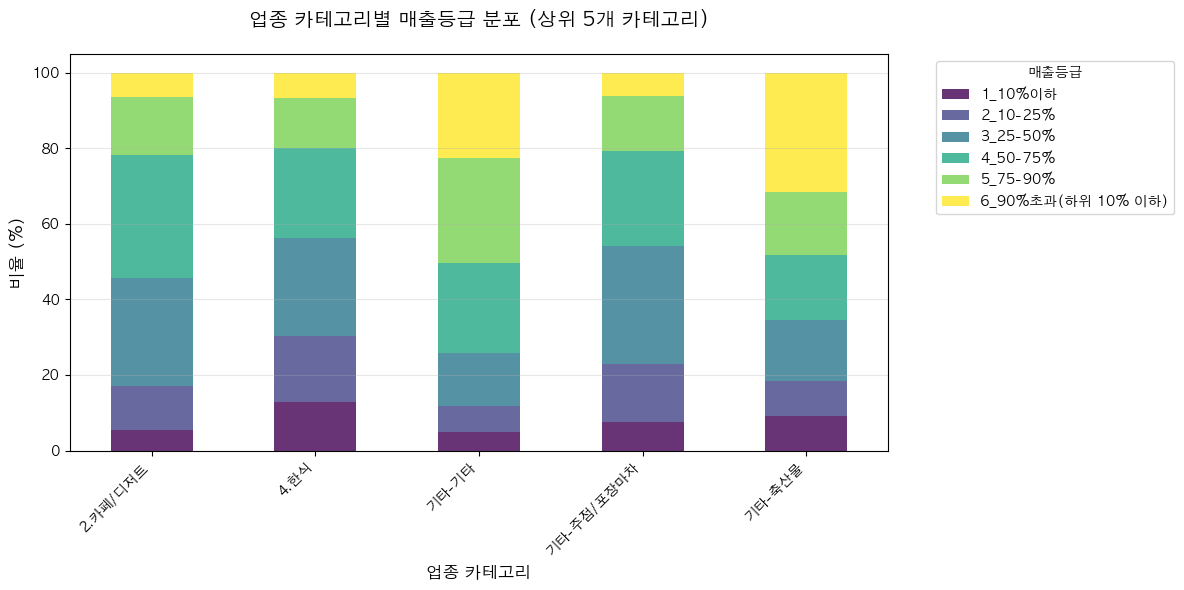

In [49]:
# 매출등급 분포 시각화
fig, ax = plt.subplots(figsize=(12, 6))

sales_dist_pct.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', alpha=0.8)
ax.set_ylabel('비율 (%)', fontsize=12)
ax.set_xlabel('업종 카테고리', fontsize=12)
ax.set_title('업종 카테고리별 매출등급 분포 (상위 5개 카테고리)', fontsize=14, fontweight='bold', pad=20)
ax.legend(title='매출등급', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 7.3 카테고리별 성별 비율

#### 7.3.1 결측치 및 특이값 처리

성별 비율 데이터는 -999999.9가 결측치로 사용되고 있으며, 유효한 범위는 0~100이다. 결측치를 제거하고 유효한 값만 사용하여 분석을 수행한다.

In [50]:
# 성별 컬럼 정의
gender_cols_male = ['M12_MAL_1020_RAT', 'M12_MAL_30_RAT', 'M12_MAL_40_RAT', 'M12_MAL_50_RAT', 'M12_MAL_60_RAT']
gender_cols_female = ['M12_FME_1020_RAT', 'M12_FME_30_RAT', 'M12_FME_40_RAT', 'M12_FME_50_RAT', 'M12_FME_60_RAT']

# 결측치 및 특이값 확인
gender_check = pd.DataFrame({
    '컬럼': gender_cols_male + gender_cols_female,
    '최소값': [df[col].min() for col in gender_cols_male + gender_cols_female],
    '최대값': [df[col].max() for col in gender_cols_male + gender_cols_female],
    '-999999.9 개수': [(df[col] == -999999.9).sum() for col in gender_cols_male + gender_cols_female],
    '유효값 개수': [(df[col] >= 0) & (df[col] <= 100).sum() for col in gender_cols_male + gender_cols_female]
})

gender_check

,컬럼,최소값,최대값,-999999.9 개수,유효값 개수
0,M12_MAL_1020_RAT,-999999.9,100.0,2004,0 False 1 False 2 False 3...
1,M12_MAL_30_RAT,-999999.9,100.0,2004,0 False 1 False 2 False 3...
2,M12_MAL_40_RAT,-999999.9,100.0,2004,0 False 1 False 2 False 3...
3,M12_MAL_50_RAT,-999999.9,100.0,2004,0 False 1 False 2 False 3...
4,M12_MAL_60_RAT,-999999.9,100.0,2004,0 False 1 False 2 False 3...
5,M12_FME_1020_RAT,-999999.9,100.0,2004,0 False 1 False 2 False 3...
6,M12_FME_30_RAT,-999999.9,100.0,2004,0 False 1 False 2 False 3...
7,M12_FME_40_RAT,-999999.9,100.0,2004,0 False 1 False 2 False 3...
8,M12_FME_50_RAT,-999999.9,100.0,2004,0 False 1 False 2 False 3...
9,M12_FME_60_RAT,-999999.9,100.0,2004,0 False 1 False 2 False 3...


In [51]:
# 성별 비율 계산 (상위 5개 카테고리, 결측치 제거)
df_gender = df[df['업종분류'].isin(top5_categories)].copy()

# 결측치(-999999.9) 제거 및 유효 범위(0-100) 필터링
for col in gender_cols_male + gender_cols_female:
    df_gender[col] = df_gender[col].replace(-999999.9, np.nan)
    df_gender[col] = df_gender[col].apply(lambda x: x if (pd.notna(x) and 0 <= x <= 100) else np.nan)

# 남성/여성 비율 합산
df_gender['남성_비율'] = df_gender[gender_cols_male].sum(axis=1)
df_gender['여성_비율'] = df_gender[gender_cols_female].sum(axis=1)

# 합산 결과가 0이거나 NaN인 경우 제외
df_gender = df_gender[(df_gender['남성_비율'] > 0) | (df_gender['여성_비율'] > 0)]

gender_summary = df_gender.groupby('업종분류')[['남성_비율', '여성_비율']].mean().round(2)
gender_summary

,남성_비율,여성_비율
업종분류,,
2.카페/디저트,43.59,56.41
4.한식,63.11,36.89
기타-기타,45.36,54.64
기타-주점/포장마차,65.57,34.43
기타-축산물,52.01,47.99


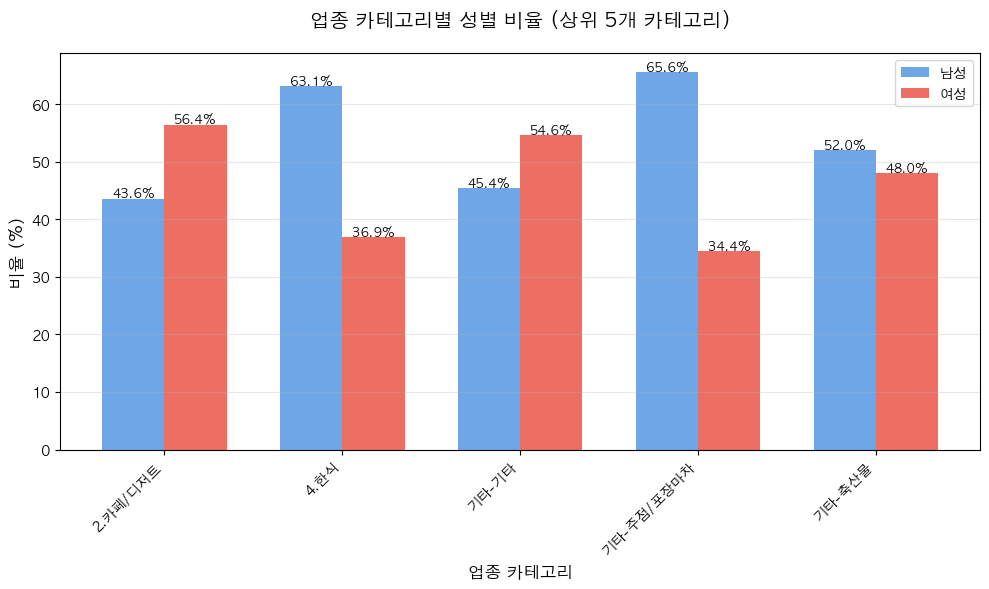

In [52]:
# 성별 비율 시각화
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(gender_summary.index))
width = 0.35

bars1 = ax.bar(x - width/2, gender_summary['남성_비율'], width, label='남성', color='#4A90E2', alpha=0.8)
bars2 = ax.bar(x + width/2, gender_summary['여성_비율'], width, label='여성', color='#E94B3C', alpha=0.8)

ax.set_ylabel('비율 (%)', fontsize=12)
ax.set_xlabel('업종 카테고리', fontsize=12)
ax.set_title('업종 카테고리별 성별 비율 (상위 5개 카테고리)', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(gender_summary.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 7.4 카테고리별 연령대 분포

#### 7.4.1 결측치 및 특이값 처리

연령대 데이터도 성별과 동일하게 -999999.9를 결측치로 처리하고, 유효한 범위(0~100)의 값만 사용한다.

In [53]:
# 연령대 비율 계산 (상위 5개 카테고리, 결측치 제거)
age_cols = gender_cols_male + gender_cols_female

df_age = df[df['업종분류'].isin(top5_categories)].copy()

# 결측치(-999999.9) 제거 및 유효 범위(0-100) 필터링
for col in age_cols:
    df_age[col] = df_age[col].replace(-999999.9, np.nan)
    df_age[col] = df_age[col].apply(lambda x: x if (pd.notna(x) and 0 <= x <= 100) else np.nan)

# 연령대별 합산 (남성 + 여성)
df_age['10~20대'] = df_age['M12_MAL_1020_RAT'].fillna(0) + df_age['M12_FME_1020_RAT'].fillna(0)
df_age['30대'] = df_age['M12_MAL_30_RAT'].fillna(0) + df_age['M12_FME_30_RAT'].fillna(0)
df_age['40대'] = df_age['M12_MAL_40_RAT'].fillna(0) + df_age['M12_FME_40_RAT'].fillna(0)
df_age['50대'] = df_age['M12_MAL_50_RAT'].fillna(0) + df_age['M12_FME_50_RAT'].fillna(0)
df_age['60대+'] = df_age['M12_MAL_60_RAT'].fillna(0) + df_age['M12_FME_60_RAT'].fillna(0)

# 모든 연령대가 0인 경우 제외
age_sum = df_age[['10~20대', '30대', '40대', '50대', '60대+']].sum(axis=1)
df_age = df_age[age_sum > 0]

age_summary = df_age.groupby('업종분류')[['10~20대', '30대', '40대', '50대', '60대+']].mean().round(2)
age_summary

,10~20대,30대,40대,50대,60대+
업종분류,,,,,
2.카페/디저트,30.94,29.33,17.39,14.34,8.00
4.한식,19.35,23.01,18.74,21.84,17.06
기타-기타,13.42,19.60,18.83,22.16,25.98
기타-주점/포장마차,27.97,27.48,15.55,17.65,11.35
기타-축산물,5.16,13.73,15.04,23.74,42.33


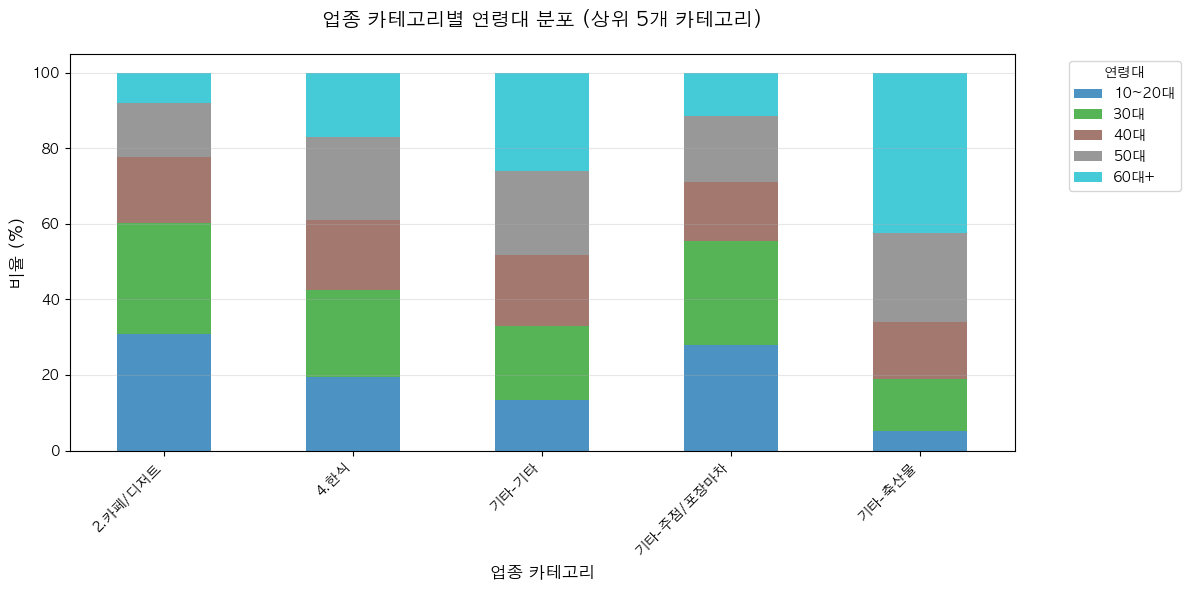

In [54]:
# 연령대 분포 시각화
fig, ax = plt.subplots(figsize=(12, 6))

age_summary.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', alpha=0.8)
ax.set_ylabel('비율 (%)', fontsize=12)
ax.set_xlabel('업종 카테고리', fontsize=12)
ax.set_title('업종 카테고리별 연령대 분포 (상위 5개 카테고리)', fontsize=14, fontweight='bold', pad=20)
ax.legend(title='연령대', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 결과 저장

In [55]:
# 업종 분류 결과 저장
output_path = '../data/업종분류_결과_최종.csv'
df[['ENCODED_MCT', 'TA_YM', 'HPSN_MCT_ZCD_NM', '업종분류']].to_csv(output_path, index=False, encoding='utf-8-sig')

pd.DataFrame([{'저장 경로': output_path, '저장 건수': len(df)}])

,저장 경로,저장 건수
0,../data/업종분류_결과_최종.csv,86590


In [56]:
# 카테고리별 통계 저장
category_stats_path = '../data/카테고리별_통계.csv'
category_delivery.to_csv(category_stats_path, encoding='utf-8-sig')

pd.DataFrame([{'저장 경로': category_stats_path, '저장 건수': len(category_delivery)}])

,저장 경로,저장 건수
0,../data/카테고리별_통계.csv,15


## 9. 결론

### 9.1 업종 분류 결과

기존 73개의 세부 업종을 배달앱(땡겨요) 카테고리 기준으로 16개 카테고리(13개 주요 + 3개 기타)로 재분류하였다.

### 9.2 주요 발견 사항

1. **한식 카테고리 분석**: 한식은 30,332개(35.03%)로 최대 비중을 차지하며, 내부적으로 배달비율 차이가 존재한다(고배달 34.82% vs 저배달 15.91%). 그러나 Cohen's d 분석 결과 대부분 "작은 차이" 수준(d=0.2~0.5)으로, 카테고리 통합 유지가 타당하다.

2. **배달비율 특성**: 피자(50.79%), 치킨(45.84%)이 배달 최고활용 업종이며, 카페/디저트(15.35%)는 배달 저활용 업종이다. 한식(29.25%)은 중활용 수준이다.

3. **축산물/주점 처리**: 축산물(6,236개)은 식자재 판매업으로 별도 분류하였으며, 주점/포장마차(5,447개)는 주류 판매 특성을 고려하여 통합 분류하였다.

4. **성별/연령대 데이터**: 결측치(-999999.9)를 제거하고 유효한 범위(0~100)의 데이터만 사용하여 분석을 수행하였다.

### 9.3 활용 방안

본 분류 결과는 가맹점 위험도 분석 시 업종별 특성을 반영한 통제변수로 활용 가능하며, 카테고리별 배달비율 임계값 도출 및 맞춤형 정책 수립에 기여할 수 있다.